## Binary Classification

In this notebook, we will work on a binary classification using the following algorithms levereging cross-validation:
- Logistic Regression
- Naive Bayes
- SVM
- KNN

In [45]:
## the general packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
## ML packages
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

### 1. Loading, Cleaning, and Exploring the Data

In [2]:
## we will be using the breast cancer data from UCI archive
data = pd.read_csv('https://archive.ics.uci.edu/static/public/15/data.csv')
data.head()

,Sample_code_number,Clump_thickness,Uniformity_of_cell_size,Uniformity_of_cell_shape,Marginal_adhesion,Single_epithelial_cell_size,Bare_nuclei,Bland_chromatin,Normal_nucleoli,Mitoses,Class
0,1000025,5,1,1,1,2,1.0,3,1,1,2
1,1002945,5,4,4,5,7,10.0,3,2,1,2
2,1015425,3,1,1,1,2,2.0,3,1,1,2
3,1016277,6,8,8,1,3,4.0,3,7,1,2
4,1017023,4,1,1,3,2,1.0,3,1,1,2


In [3]:
## checking out the types and the existence of nulls in the colums
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Sample_code_number           699 non-null    int64  
 1   Clump_thickness              699 non-null    int64  
 2   Uniformity_of_cell_size      699 non-null    int64  
 3   Uniformity_of_cell_shape     699 non-null    int64  
 4   Marginal_adhesion            699 non-null    int64  
 5   Single_epithelial_cell_size  699 non-null    int64  
 6   Bare_nuclei                  683 non-null    float64
 7   Bland_chromatin              699 non-null    int64  
 8   Normal_nucleoli              699 non-null    int64  
 9   Mitoses                      699 non-null    int64  
 10  Class                        699 non-null    int64  
dtypes: float64(1), int64(10)
memory usage: 60.2 KB


The only column with null values is the `Bare_nuclei`. The types are all `int64`, which could certainly be converted to `int8` or `int16`. 

The other modification can be to remove the `Sample_code_number` column, which seems to be an identifier, with no real value for our model.

In [5]:
## checking to see if the missing values
## belong to a specific class
data[data['Bare_nuclei'].isnull()]['Class'].value_counts()

Class
2    14
4     2
Name: count, dtype: int64

as it turned out, the majority of the missing values belong to the `2 = benign` class.

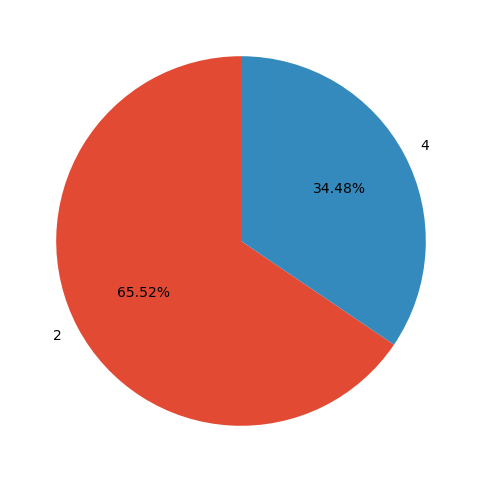

In [47]:
## plotting the ditribution of the classes in our data
class_vals = data.Class.value_counts()
plt.figure(figsize = (6,6))
plt.pie(x = class_vals.values, labels = class_vals.index,
       autopct='%1.2f%%', startangle=90);

Majority of our samples are of class 2, which means we have an unbalanced dataset, and we can drop the samples with null values, since given the ditribution, they will not have a major impact on our model later on.

In [23]:
## some data cleaning 
def data_cleaner(df, drop_cols = None):
    ## first, getting rid of the columns passed
    if drop_cols:
        df = df.drop(drop_cols, axis=1)
    ## lowercasing the column names
    ## and removing the extra spaces
    df.columns = [x.strip().replace(r'\s+', '_').lower() for x in df.columns]
    ## removing the null values
    df = df.dropna()
    type_dict = {}
    for col in df.columns:
        if df[col].dtype == 'float64' and df[col].min() == df.astype({col:'int8'})[col].min():
            type_dict[col] = 'int8'
        elif df[col].dtype == 'float64' and df[col].min() == df.astype({col:'float16'})[col].min():
            type_dict[col] = 'float16'
        elif df[col].dtype == 'int64' and df[col].min() == df.astype({col:'int8'})[col].min():
            type_dict[col] = 'int8'
        elif df[col].dtype == 'int64' and df[col].min() == df.astype({col:'int16'})[col].min():
            type_dict[col] = 'int16'
    return df.astype(type_dict)
cleaned_data = data_cleaner(data.copy(), drop_cols = ['Sample_code_number'])
cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 683 entries, 0 to 698
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype
---  ------                       --------------  -----
 0   clump_thickness              683 non-null    int8 
 1   uniformity_of_cell_size      683 non-null    int8 
 2   uniformity_of_cell_shape     683 non-null    int8 
 3   marginal_adhesion            683 non-null    int8 
 4   single_epithelial_cell_size  683 non-null    int8 
 5   bare_nuclei                  683 non-null    int8 
 6   bland_chromatin              683 non-null    int8 
 7   normal_nucleoli              683 non-null    int8 
 8   mitoses                      683 non-null    int8 
 9   class                        683 non-null    int8 
dtypes: int8(10)
memory usage: 12.0 KB


Now, we're ready for some more in-depth visualizations.

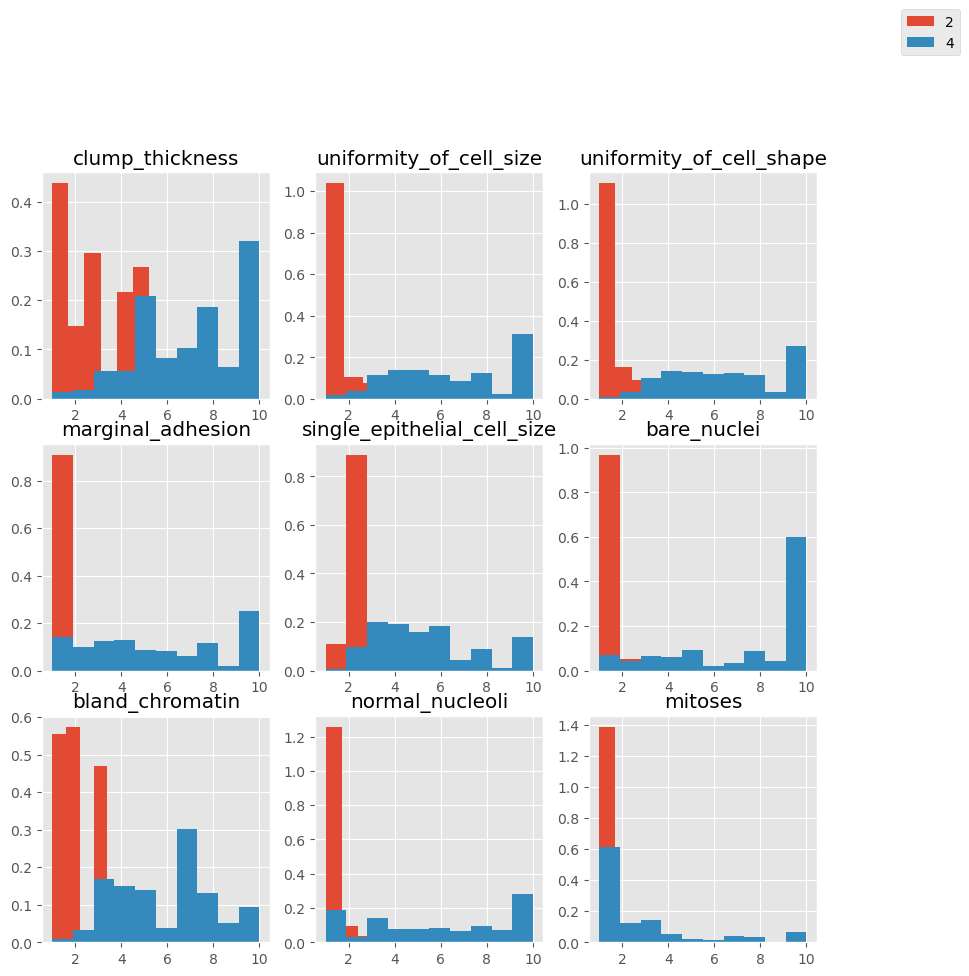

In [48]:
plt.figure(figsize = (10, 10))
c = 1
nrows, ncols = 3, 3
for col in cleaned_data.drop('class', axis=1).columns:
    for l in class_vals.index:
        plt.subplot(nrows, ncols, c)
        plt.hist(cleaned_data[cleaned_data['class']==l][col], 
                  density=True, label=l)
        plt.title(col)
    c+=1
handels, labels = plt.gca().get_legend_handles_labels()
fig.tight_layout()
plt.figlegend(handels, labels, bbox_to_anchor=[1.05, 1.05]);

We do see some differences in the distribution for each class, the only feature that might be having a very similar distrivution for both classes is `mitoses`.

### 2. Staring with the Model

#### 2.1. Logistic Regression
We will start with a simple logistic regression as our first model

In [49]:
## we need to first split and then scale our data
## we will also be changing the label values to 1 = malignant, and 0 = benign
X, y = cleaned_data.drop('class', axis=1), (cleaned_data['class'] == 4).astype(int)
X_train, X_test, y_train, y_test = train_test_split()


0    0
1    0
2    0
3    0
4    0
Name: class, dtype: int32